## Project 3
- Mike Ames 
- amesam@wfu.edu
- 18May2020

### Load Packages
-------



In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.ensemble import ExtraTreesClassifier      #- random trees 
from sklearn.ensemble import RandomForestClassifier    #- random forest classifier 

# -- we need these to make our pipelines 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# -- we need these to evaluate our models 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# -- categorical encoders -- 
from category_encoders import *


# -- need this to render charts in notebook -- 
%matplotlib inline


## Tasks 

### Part 0 
1. pip install category_encoders  https://github.com/scikit-learn-contrib/category_encoders

read http://contrib.scikit-learn.org/category_encoders/


### Part 1
1. Stage data
2. Clean up column names 
3. Describe data 
4. Explore likely predictors  

### Part 2.
5. Partition into 75/25 split 
6. Train 2 ExtraTrees Classifiers
    - onehot encoding 
    - target encoding  
    - feature importance 

7. Train 2 RandomForest Classifiers 
    - onehot encoding
    - target encoding 
    - feature importance 
    
8. Evaluate & Compare Performance of Each 
    -	Receiver Operator Characteristic (ROC Chart) 
    -	Area Under the Curve (AUC)
    -	Recal(TPR) @1% FPR  


### Part 3.  
8. Write up your thoughts. 

# Part 1. 
## 1. Stage 
----- 
import our dataset into a pandas dataframe

In [2]:
df = pd.read_csv("./data/adult.csv",na_values="?")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## 2.  Clean up Column Names

*It's just not fun dealing with ill-formed columns*

- remove leading and trailing characters
- replace spaces with underscores _ 
- change case to lower case
- remove various special characters

In [3]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
print(df.columns)

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational_num',
       'marital_status', 'occupation', 'relationship', 'race', 'gender',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


## 3. Describe data

### Check Target
-----

Always start by understanding your "target" value 


<div class="alert-success"> 💡  <strong> Comentary </strong>


- Below you can see that 24% are >50K earners, while 76% are <=50K, we also see that we have a good amount of records(48k) 
 
</div>


In [4]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [5]:
df['income'].value_counts(normalize=True)

<=50K    0.760718
>50K     0.239282
Name: income, dtype: float64

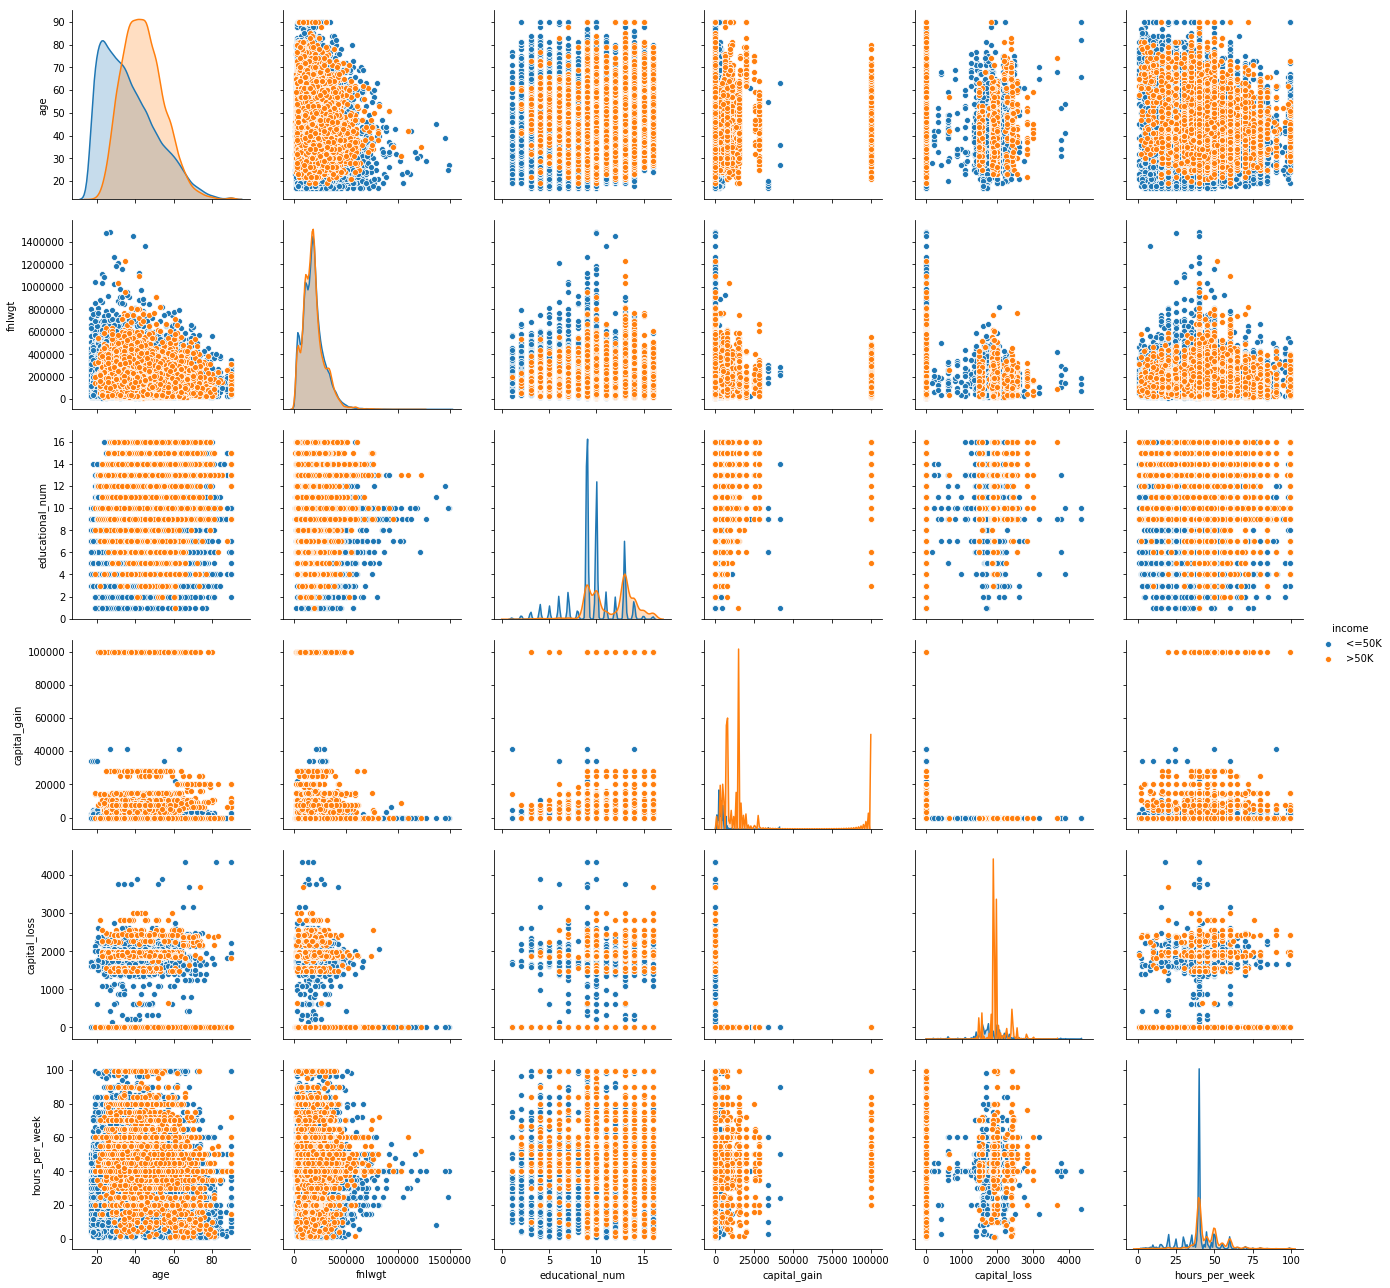

In [6]:
# -- 2uestion what does a pairs plot do? 
sns.pairplot(df, hue='income', height=3)

# Part 2.
## 5. Partition into 75/25 split 


In [7]:
## Convert income to a 0 / 1 
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].value_counts(normalize=True)

0    0.760718
1    0.239282
Name: income, dtype: float64

In [8]:
train, test = train_test_split(df,test_size=0.30)
print("train pct: {:2.2%}".format(train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(test.shape[0]/df.shape[0]))


train pct: 70.00%
test  pct: 30.00%


## 6. Train a ExtraTreesClassifier 


### About ExtraTreesClassifier

Each Decision Tree in the Extra Trees Forest is constructed from the original training sample. Then, at each test node, Each tree is provided with a random sample of k features from the feature-set from which each decision tree must select the best feature to split the data based on some mathematical criteria (typically the Gini Index). This random sample of features leads to the creation of multiple de-correlated decision trees

-----

   #### n_estimatorsint, default=100
    The number of trees in the forest.

   #### criterion{“gini”, “entropy”}, default=”gini”
    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

   ####  splitter{“best”, “random”}, default=”best”
    The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

   #### max_depth, default=None
    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

   #### min_samples_split, default=2
    The minimum number of samples required to split an internal node:


### Build a Pipeline 
-------
Why a pipeline? most ML models can't or won't explicitly handle string data we have to convert it to a number. 

What are my options. Well there are two options.
1. manually deal with missing values, pd.fillna will do the job 
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html 
2. mannually create 0/1s,  pd.get_dummies will do that too 
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
    
The problem is that this works for academic datasets but doesn't work in the real-world. in the real-world data is messy what happens when you get a new level in one of your categorical variables, more hand coding. No manually dealing with missing values and categorical varaibles is a lot fo work for very little gain. The best pratice is to use a pipeline! 





In [9]:
# 1. Split features into categorical and numeric 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        "marital_status",
                        "workclass",
                        "occupation",
                        "education"] 

## Create our Pipeline 



In [10]:
# -- this is your pipeline based model -- 

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', use_cat_names=True)) #-- note this is from category-encoders not kslearn 
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

extra_trees = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', ExtraTreesClassifier( n_estimators=100, 
                                          max_depth = 20,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                           n_jobs=-1,
                                          random_state=42))
])

extra_trees = extra_trees.fit(train[categorical_features + numeric_features], train[target])
extra_trees

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [35]:
pd.crosstab(train["relationship"],train[target], normalize="index").reset_index()

income,relationship,0,1
0,Husband,0.551589,0.448411
1,Not-in-family,0.898478,0.101522
2,Other-relative,0.956814,0.043186
3,Own-child,0.985072,0.014928
4,Unmarried,0.941808,0.058192
5,Wife,0.538320,0.461680


In [37]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train["relationship"])
le.transform(["Husband", "Not-in-family", "Not-in-family", "Unmarried"])

array([0, 1, 1, 4])

In [39]:
# Frequency Encoding 
fe = train.groupby("relationship").size()/len(train)
fe

relationship
Husband           13811
Not-in-family      8806
Other-relative     1042
Own-child          5359
Unmarried          3540
Wife               1631
dtype: int64

In [12]:
# -- this is your pipeline based model -- 

categorical_pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('trgenc', TargetEncoder()) #-- note this is from category-encoders not sklearn 
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe2, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

rf_pipe = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier( n_estimators=100, 
                                        max_depth = 20,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                        n_jobs=-1,
                                          random_state=42))
])

rf = rf_pipe.fit(train[categorical_features + numeric_features], train[target])
rf

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

### Extract Transformed Feature Names, 

this just makes life easier... we need to get the new feature names from the transformed data specifically from the categorical transformer. Since we use onehot encoding we turn all categories into new columns with 0/1s. 

In [13]:
# -- gets the feature names 
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names()

# -- creates one list of all the feature names. 
feature_names =  transformed_categorical + numeric_features
print(transformed_categorical)

['0_Male', '0_Female', '1_Unmarried', '1_Own-child', '1_Husband', '1_Not-in-family', '1_Wife', '1_Other-relative', '2_Never-married', '2_Married-civ-spouse', '2_Separated', '2_Married-spouse-absent', '2_Divorced', '2_Married-AF-spouse', '2_Widowed', '3_Self-emp-not-inc', '3_missing', '3_Private', '3_Federal-gov', '3_State-gov', '3_Local-gov', '3_Self-emp-inc', '3_Without-pay', '3_Never-worked', '4_Sales', '4_missing', '4_Other-service', '4_Adm-clerical', '4_Prof-specialty', '4_Machine-op-inspct', '4_Craft-repair', '4_Farming-fishing', '4_Protective-serv', '4_Tech-support', '4_Exec-managerial', '4_Handlers-cleaners', '4_Transport-moving', '4_Priv-house-serv', '4_Armed-Forces', '5_Bachelors', '5_HS-grad', '5_Assoc-acdm', '5_Masters', '5_Assoc-voc', '5_11th', '5_Some-college', '5_10th', '5_Prof-school', '5_7th-8th', '5_12th', '5_5th-6th', '5_1st-4th', '5_9th', '5_Doctorate', '5_Preschool']


## useful python trick... 

```python
for counter, value in enumerate(some_list):
    print(counter, value)
```

In [14]:
importance = extra_trees['classifier'].feature_importances_
importance

array([2.02775766e-02, 2.30399784e-02, 8.22752914e-03, 1.92779548e-02,
       8.72361578e-02, 2.30752943e-02, 2.21034287e-02, 1.31029365e-03,
       8.14564388e-02, 1.54668584e-01, 2.42640143e-03, 9.60805381e-04,
       1.12564967e-02, 3.80169685e-04, 2.10303969e-03, 9.48745129e-03,
       2.11567270e-03, 6.37738922e-03, 6.08213950e-03, 2.46674070e-03,
       3.18091439e-03, 9.88663018e-03, 2.28996397e-05, 1.44265551e-09,
       6.04802355e-03, 2.50435463e-03, 1.65950216e-02, 3.09164257e-03,
       4.06058312e-02, 3.28290384e-03, 4.18287813e-03, 5.08217234e-03,
       1.07909710e-03, 4.20955088e-03, 5.03530630e-02, 3.47802257e-03,
       2.06534782e-03, 9.83544462e-05, 7.46911846e-06, 3.72947334e-02,
       1.67607992e-02, 2.43740080e-03, 2.38337976e-02, 2.81720538e-03,
       3.92405789e-03, 8.12904771e-03, 2.93626517e-03, 1.43921510e-02,
       4.59905736e-03, 7.21615220e-04, 1.08864472e-03, 3.61246262e-04,
       2.51892994e-03, 1.12635450e-02, 7.93023150e-05, 3.80394463e-02,
      

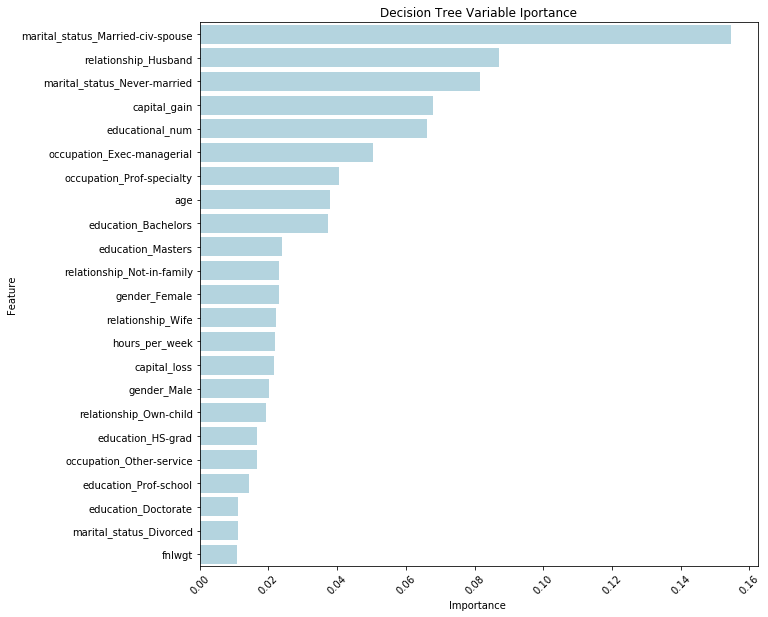

In [15]:

# -- get feature importance 
importance = extra_trees['classifier'].feature_importances_

# -- summarize feature importance into a dictionary 
feature_imp ={}
for i,v in enumerate(importance):
    items = feature_names[i].split('_')
    if items[0].isdigit():
        fname = categorical_features[int(items[0])] + "_" + items[1]
        feature_imp[fname] = v
    else:
        feature_imp[feature_names[i]] = v
        #print(items[0].isdigit())
        #print(items)
    #if int(items[0]) >= 0:  
    #print(categorical_features[int(items[0])])

# make the dictionary a data frame 
feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                     columns=['importance'])

# -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
feature_imp = (feature_imp
               .reset_index()
               .rename(columns={'index':'feature'})
               .sort_values('importance',ascending=False)
               .query('importance > 0.01'))

# -- plot that 
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
plt.title('Extra Trees Variable Iportance')
plt.ylabel('Feature')
plt.xlabel('Importance ')
plt.xticks(rotation=45)
plt.show()




In [43]:
import sys
!pip install rfpimp

    100% |████████████████████████████████| 163kB 1.4MB/s ta 0:00:01
  Stored in directory: /Users/mikames/Library/Caches/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Stored in directory: /Users/mikames/Library/Caches/pip/wheels/7f/44/3a/110013d8115971c482c5537fe898ae1168436f6370115f665f
Successfully built rfpimp stratx


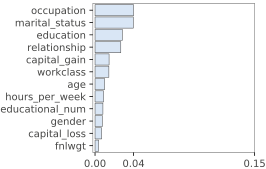

In [48]:

I = importances(extra_trees, train[categorical_features + numeric_features], train[target])
plot_importances(I)


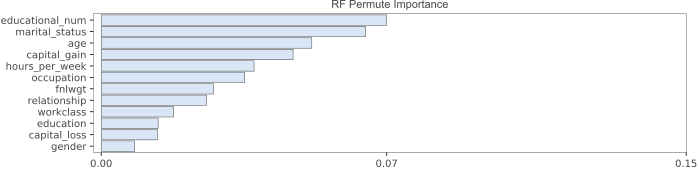

In [57]:

from rfpimp import *

I = importances(rf, train[categorical_features + numeric_features], train[target])
plot_importances(I, width=10, title="RF Permute Importance")


##  Evaluate Performance 
-----

Here we want to compare the accuracy and confusion matrix of our decision tree pipeline on both our training data and test data. Sklearn provides two convient function to apply our models 

    .predict() - predicts the "label" or "target" on a new data set. This method accepts one argument, the new data set (e.g. model. predict(X_new) ), and returns the learned label for row. in our case it will return a 1 for income >50K and a 0 for <=50K
    
    .predict_proba() -  gives us the probabilities for the target (0 and 1) in array form. The number of probabilities for each row is equal to the number of categories in target variable. 
    
-----
1. Apply to training data 
2. Apply to testing data
3. Compare accuracy and confusion matrix 


In [16]:
train['income_pred'] = extra_trees.predict(train[numeric_features + categorical_features])
train_probabilites = extra_trees.predict_proba(train[numeric_features + categorical_features])
train['income_p0'] = train_probabilites[:,0]
train['income_p1'] = train_probabilites[:,1]
train.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,income_pred,income_p0,income_p1
47544,30,Self-emp-not-inc,223212,Bachelors,13,Never-married,Sales,Unmarried,White,Male,0,0,40,United-States,0,0,0.836040,0.163960
30722,18,NaN,216508,HS-grad,9,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,0,0,0.999166,0.000834
3012,25,Private,105930,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0,0,0.998868,0.001132
18482,28,Federal-gov,183151,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,60,United-States,0,0,0.604312,0.395688
10071,33,State-gov,204374,Masters,14,Never-married,Prof-specialty,Own-child,White,Male,0,0,38,Poland,0,0,0.952017,0.047983


In [17]:
test['income_pred'] = extra_trees.predict(test[numeric_features + categorical_features])
test_probabilites = extra_trees.predict_proba(test[numeric_features + categorical_features])
test['income_p0'] = test_probabilites[:,0]
test['income_p1'] = test_probabilites[:,1]
test.head()

,age,workclass,fnlwgt,education,educational_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income,income_pred,income_p0,income_p1
6011,39,Private,116477,Assoc-voc,11,Divorced,Tech-support,Not-in-family,White,Female,0,0,40,United-States,0,0,0.975930,0.024070
41311,43,Private,239161,Some-college,10,Married-civ-spouse,Sales,Husband,Amer-Indian-Eskimo,Male,0,0,40,United-States,0,0,0.562821,0.437179
27458,32,Private,222221,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,7298,0,42,United-States,1,1,0.327237,0.672763
12275,25,Private,131341,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,36,Cuba,0,0,0.988353,0.011647
9712,34,State-gov,62327,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0,1,0.379604,0.620396


Training confusion Matrix
Predicted      0     1
Actual                
0          24654  1364
1           3135  5036


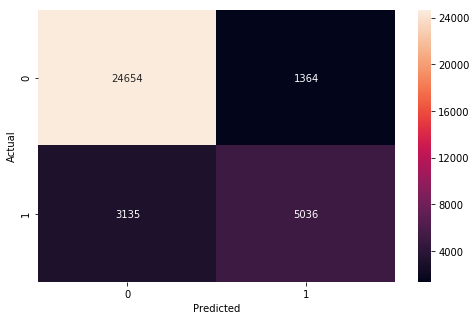

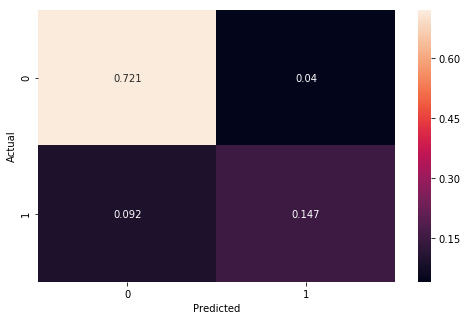

In [18]:
print("Training confusion Matrix")
confusion_matrix = pd.crosstab(train['income'], train['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_pct = pd.crosstab(train['income'], train['income_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted']).round(3)
print (confusion_matrix)

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix_pct, annot=True, fmt='g')
plt.show()

Test confusion Matrix
Predicted      0     1
Actual                
0          10447   690
1           1490  2026


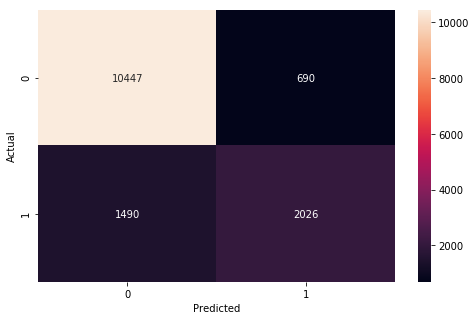

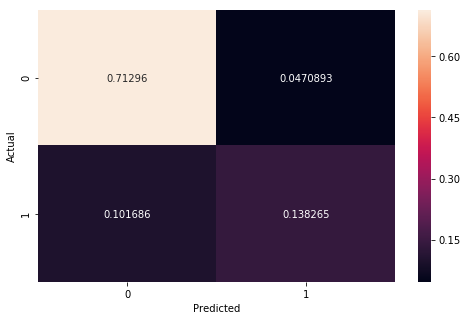

In [19]:
print("Test confusion Matrix")
confusion_matrix = pd.crosstab(test['income'], test['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_pct = pd.crosstab(test['income'], test['income_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix, annot=True, fmt='g')
plt.show()

plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix_pct, annot=True, fmt='g')
plt.show()

In [20]:
from sklearn.metrics import accuracy_score
### Default Accuracy, i.e. do nothing predict everyone as <50K, is the same as saying what % of <50K 
accuracy_default = train['income'].value_counts(normalize='True')[0]
accuracy_train = accuracy_score(train['income'], train['income_pred'])
accuracy_test = accuracy_score(test['income'], test['income_pred'])
print("Default Accuracy : {:2.2%}".format(accuracy_default))
print("Train Accuracy   : {:2.2%}".format(accuracy_train))
print("Test Accuracy    : {:2.2%}".format(accuracy_test))

Default Accuracy : 76.10%
Train Accuracy   : 86.84%
Test Accuracy    : 85.12%


In [21]:
def model_accuracy(model, model_name):
    test['income_pred'] = model.predict(test[numeric_features + categorical_features])
    ### Default Accuracy, i.e. do nothing predict everyone as <50K, is the same as saying what % of <50K 
    accuracy_default = train['income'].value_counts(normalize='True')[0]
    accuracy_train = accuracy_score(train['income'], train['income_pred'])
    accuracy_test = accuracy_score(test['income'], test['income_pred'])
    print("--" + model_name + " model accuracy report --")
    print("Default Accuracy : {:2.2%}".format(accuracy_default))
    print("Train Accuracy   : {:2.2%}".format(accuracy_train))
    print("Test Accuracy    : {:2.2%}".format(accuracy_test))
    print("\n")
    
    
model_accuracy(extra_trees,"extra trees")
model_accuracy(rf, "random forest")

--extra trees model accuracy report --
Default Accuracy : 76.10%
Train Accuracy   : 86.84%
Test Accuracy    : 85.12%


--random forest model accuracy report --
Default Accuracy : 76.10%
Train Accuracy   : 86.84%
Test Accuracy    : 86.81%




In [22]:
rf['classifier'].feature_importances_

array([0.01570764, 0.07298494, 0.17915501, 0.02957559, 0.0528701 ,
       0.02696135, 0.11612302, 0.08996252, 0.13739983, 0.16379193,
       0.04582976, 0.0696383 ])

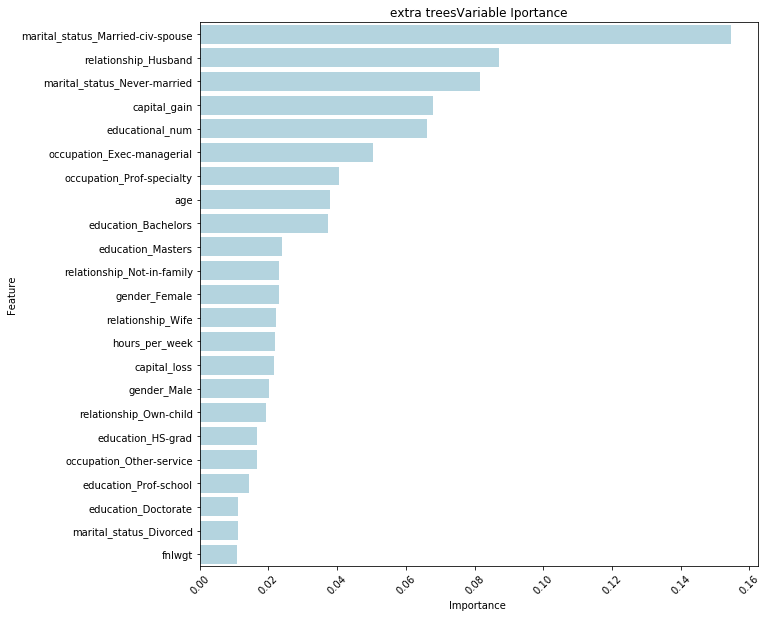

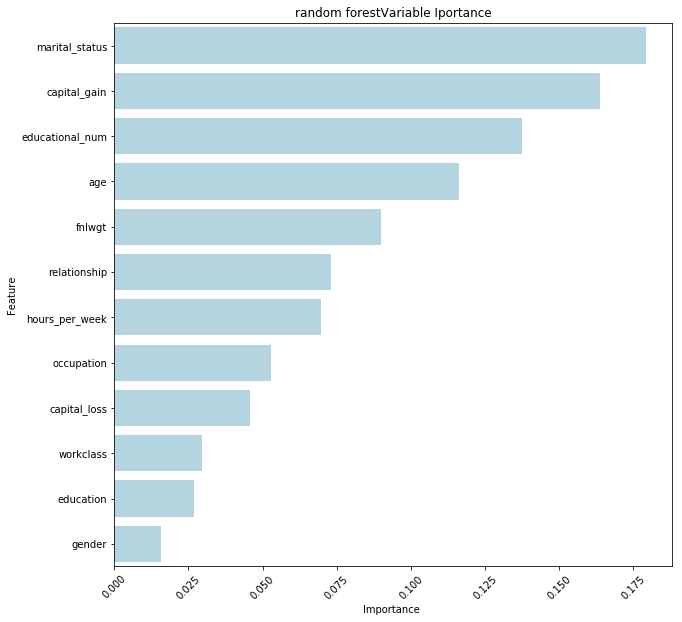

In [23]:
def model_var_importance(model, model_name, feature_names):
    
    # -- get feature importance 
    importance = model['classifier'].feature_importances_

    # -- summarize feature importance into a dictionary 
    feature_imp ={}
    for i,v in enumerate(importance):
        items = feature_names[i].split('_')
        if items[0].isdigit():
            fname = categorical_features[int(items[0])] + "_" + items[1]
            feature_imp[fname] = v
        else:
            feature_imp[feature_names[i]] = v
            #print(items[0].isdigit())
            #print(items)
        #if int(items[0]) >= 0:  
        #print(categorical_features[int(items[0])])

    # make the dictionary a data frame 
    feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                         columns=['importance'])

    # -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
    feature_imp = (feature_imp
                   .reset_index()
                   .rename(columns={'index':'feature'})
                   .sort_values('importance',ascending=False)
                   .query('importance > 0.01'))

    # -- plot that 
    plt.figure(figsize=(10,10))
    sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
    plt.title( model_name + 'Variable Iportance')
    plt.ylabel('Feature')
    plt.xlabel('Importance ')
    plt.xticks(rotation=45)
    plt.show()

    
# -- gets the feature names for 1-hot encoding 
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names()

# -- creates one list of all the feature names. 
feature_names =  transformed_categorical + numeric_features

model_var_importance(extra_trees, "extra trees", feature_names )
feature_names =  categorical_features + numeric_features
model_var_importance(rf, "random forest", feature_names)

extra trees - Training confusion Matrix
extra trees - Testing confusion Matrix


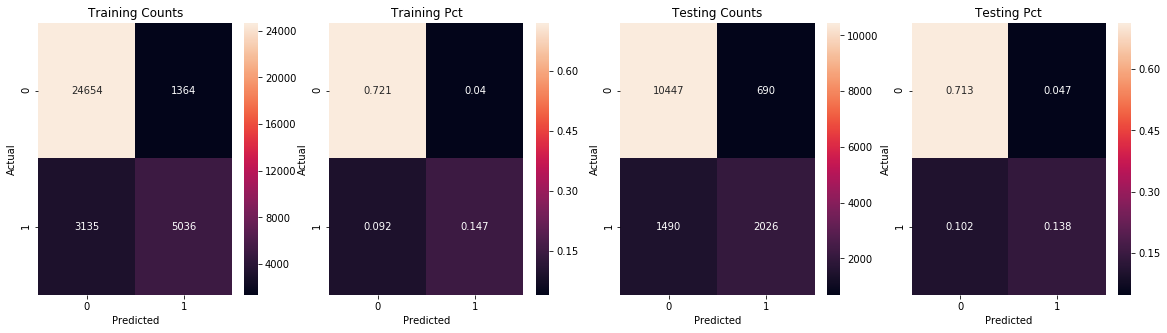

random forest - Training confusion Matrix
random forest - Testing confusion Matrix


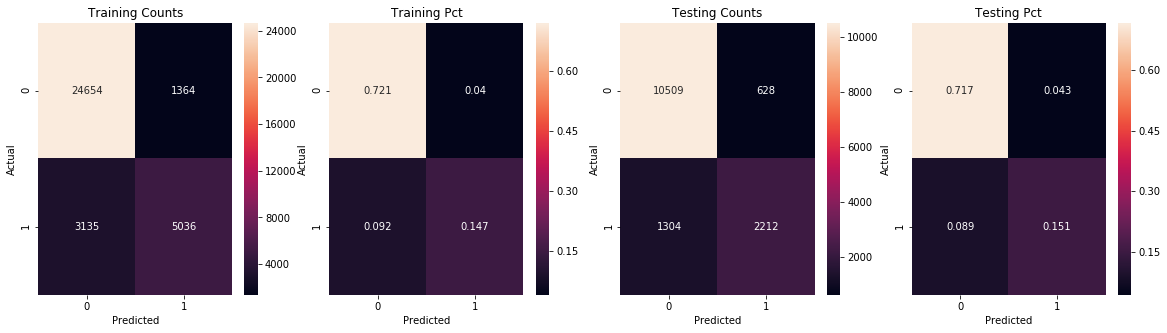

In [24]:
def model_confusion_matrix(model, model_name):
    test['income_pred'] = model.predict(test[numeric_features + categorical_features])
     
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    
    print(model_name + " - Training confusion Matrix")
    confusion_matrix = pd.crosstab(train['income'], train['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(train['income'], train['income_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted']).round(3)
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax1)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g', ax=ax2)
    
    #plt.show()
    #fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    print(model_name + " - Testing confusion Matrix")
    confusion_matrix = pd.crosstab(test['income'], test['income_pred'],  rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix_pct = pd.crosstab(test['income'], test['income_pred'], normalize="all", rownames=['Actual'], colnames=['Predicted']).round(3)


    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax3)
    sns.heatmap(confusion_matrix_pct, annot=True, fmt='g', ax=ax4)
    
    ax1.title.set_text('Training Counts')
    ax2.title.set_text('Training Pct')
    ax3.title.set_text('Testing Counts')
    ax4.title.set_text('Testing Pct')
    
    plt.show()
    
    
model_confusion_matrix(extra_trees, "extra trees")
model_confusion_matrix(rf, "random forest")

--- Extra Trees  ---
Train AUC Score        : 0.933361
Test AUC Score         : 0.903338


--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.17       0.79
1  0.02  0.31       0.70
2  0.03  0.39       0.64
3  0.04  0.46       0.60
4  0.05  0.51       0.55




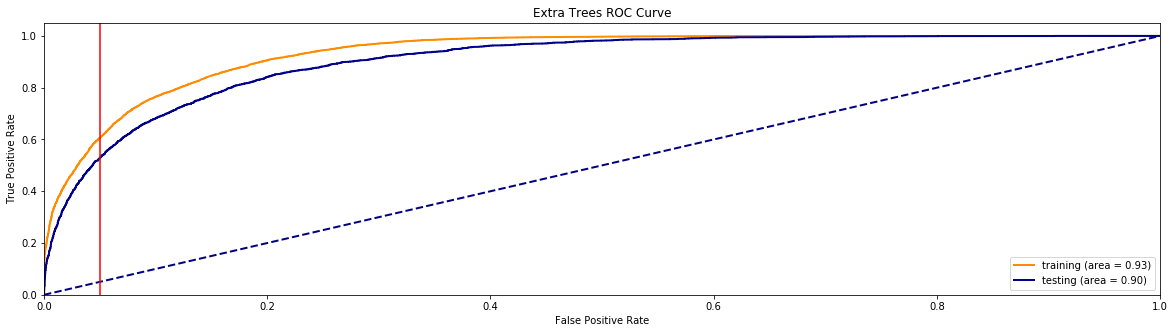

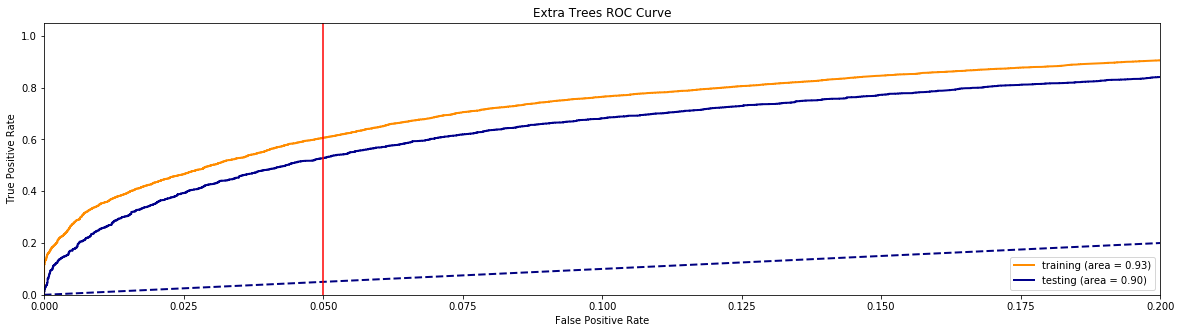

--- Random Forest ---
Train AUC Score        : 0.977297
Test AUC Score         : 0.918228


--- TEST score thresholds ---
    fpr   tpr  threshold
0  0.01  0.34       0.79
1  0.02  0.43       0.70
2  0.03  0.50       0.63
3  0.04  0.55       0.58
4  0.05  0.59       0.54




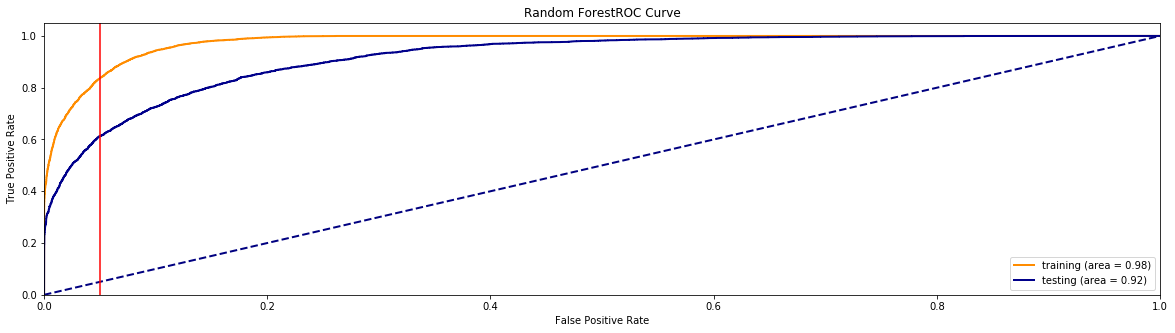

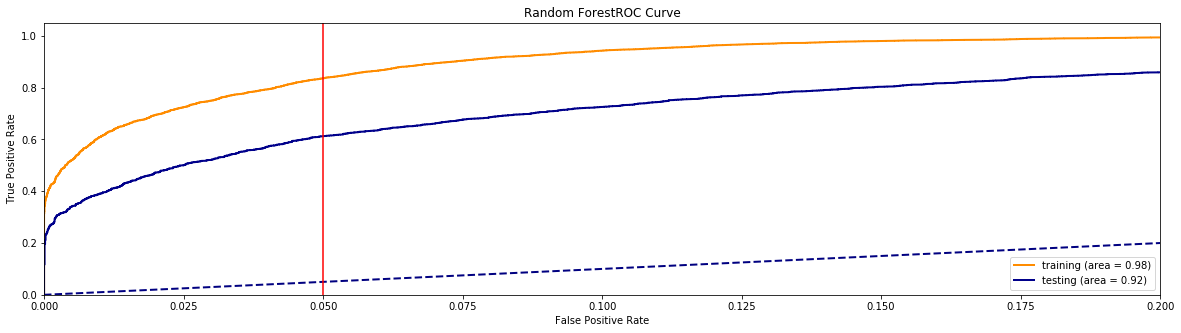

In [49]:


def model_auc_roc(model, model_name):
    
    #- 1. predict on train and test 
    train_predict_proba = model.predict_proba(train[numeric_features + categorical_features])[:,1]
    test_predict_proba = model.predict_proba(test[numeric_features + categorical_features])[:,1]
    
    #- 2. get fpr, tpr and threshold for train and test 
    train_fpr, train_tpr, train_thr = roc_curve(train[target], train_predict_proba)
    test_fpr, test_tpr, test_thr = roc_curve(test[target], test_predict_proba)
    
    #- 3. get auc and threshold for train and test 
    train_auc = auc( train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    
    #- 4. Print performance 
    print ("--- " + model_name + " ---")
    print ("Train AUC Score        : %f" % train_auc)
    print ("Test AUC Score         : %f" % test_auc)
    print ("\n")
   
    #- 5. FPR from 1 - 5% 
    model_stat = pd.concat([
        pd.DataFrame(test_fpr).rename(columns={0:'fpr'}),
        pd.DataFrame(test_tpr).rename(columns={0:'tpr'}),
        pd.DataFrame(test_thr).rename(columns={0:'threshold'})
        ],axis=1
        ).round(decimals=2)
   
    # - just get 1% FPR increments o
    m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()]    
    

    print("--- TEST score thresholds ---")
    print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.05)].reset_index(drop=True))
    print("\n")
    
    #- 6. plot
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( model_name + 'ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(figsize=(20, 5))
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=2, label='training (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='darkblue',
             lw=2, label='testing (area = %0.2f)' % test_auc)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 0.2])
    plt.ylim([0.0, 1.05])
    plt.axvline(x= 0.05,  color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( model_name + 'ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    
    

model_auc_roc(extra_trees, "Extra Trees ")  
model_auc_roc(rf, "Random Forest")  

## 8. Thoughts


<div class="alert-success"> 💡  <strong> Comentary </strong>

Well our decison tree is a lot more accurate than our rule, if we looked at our rule from the previous project we had a accuracy of 53% on both training and test, which is much worse than just doing nothing (76% accurate). Here we are 87% accurate on the trainig set and 85.5% on the test set, significantly better at predicting income. 

Key things to note:  
1. tree depth plays a big role in a tree's abilty to predict 
2. based on the analysis below, by removing the marital_status(the first split feature) we get similar performance? whats going on? 
3. marital_status and relationship appear to have similar importance 

I wonder how we can take advantage of this feature of decision trees to improve their performance? 

</div>


In [26]:
# -- remove marital_status and retrain 
target = 'income'

numeric_features = ['age',
                    "fnlwgt", 
                    "educational_num",
                    "capital_gain",
                    "capital_loss",
                    "hours_per_week"]

categorical_features = ["gender",
                        "relationship",
                        "marital_status",
                        "workclass",
                        "occupation",
                        "education"] 


In [27]:
# -- this is your pipeline based model -- 
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_features),
    ('num', numerical_pipe, numeric_features)
    ])

rf_pipe = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(max_depth = 10,
                                          min_samples_leaf = 2, 
                                          criterion = 'gini',
                                          random_state=42))
])

rf2 = rf_pipe.fit(train[categorical_features + numeric_features], train[target])
rf2

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [28]:
train['income_pred'] = rf2.predict(train[numeric_features + categorical_features])
train_probabilites = rf2.predict_proba(train[numeric_features + categorical_features])
train['income_p0'] = train_probabilites[:,0]
train['income_p1'] = train_probabilites[:,1]

test['income_pred'] = rf2.predict(test[numeric_features + categorical_features])
test_probabilites = rf2.predict_proba(test[numeric_features + categorical_features])
test['income_p0'] = test_probabilites[:,0]
test['income_p1'] = test_probabilites[:,1]


accuracy_default = train['income'].value_counts(normalize='True')[0]
accuracy_train = accuracy_score(train['income'], train['income_pred'])
accuracy_test = accuracy_score(test['income'], test['income_pred'])
print("Default Accuracy : {:2.2%}".format(accuracy_default))
print("Train Accuracy   : {:2.2%}".format(accuracy_train))
print("Test Accuracy    : {:2.2%}".format(accuracy_test))

Default Accuracy : 76.10%
Train Accuracy   : 86.46%
Test Accuracy    : 86.23%


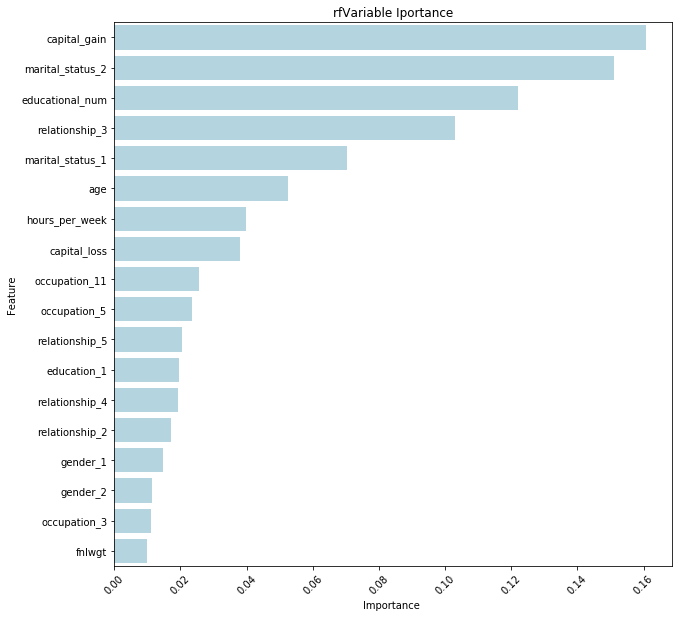

In [29]:
categorical_pipe.fit_transform(train[categorical_features])
transformed_categorical = categorical_pipe['onehot'].get_feature_names()
feature_names =  transformed_categorical + numeric_features

model_var_importance(rf2, "rf", feature_names)



In [30]:

# -- get feature importance 
importance = decision_tree2['classifier'].feature_importances_

# -- summarize feature importance into a dictionary 
feature_imp ={}
for i,v in enumerate(importance):
    feature_imp[feature_names[i]] = v

# make the dictionary a data frame 
feature_imp = pd.DataFrame.from_dict(feature_imp, orient='index',
                                     columns=['importance'])

# -- prep and filter our dataframe, only need to look at the important features i.e. things > 0 
feature_imp = (feature_imp
               .reset_index()
               .rename(columns={'index':'feature'})
               .sort_values('importance',ascending=False)
               .query('importance > 0.01'))

# -- plot that 
plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=feature_imp, color="lightblue")
plt.title('Decision Tree Variable Iportance')
plt.ylabel('Feature')
plt.xlabel('Importance ')
plt.xticks(rotation=45)
plt.show()


NameError: name 'decision_tree2' is not defined